**Dataset:** `students_mental_health_survey.csv`

**Variável Alvo:** `Depression_Score`

**Variáveis Preditoras Selecionadas (para o Modelo):**
* `Semester_Credit_Load` (Numérica)
* `Sleep_Quality` (Ordinal: Poor=0, Average=1, Good=2)
* `Course` (Nominal: One-Hot Encoded)
* `Financial_Stress` (Numérica: 0-5)
* `Physical_Activity` (Ordinal: Low=0, Moderate=1, High=2)
* `Diet_Quality` (Ordinal: Poor=0, Average=1, Good=2)
* `Social_Support` (Ordinal: Low=0, Moderate=1, High=2)
* `CGPA` (Numérica)

**Modelo Base:** Regressão Linear Múltipla

In [43]:
# Importar bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
import warnings

# Configurações
warnings.filterwarnings('ignore') # Ignorar avisos
plt.rcParams['figure.figsize'] = [12, 6] # Tamanho padrão das figuras
pd.set_option('display.max_columns', None) # Mostrar todas as colunas
pd.set_option('display.width', 1000) # Largura maior para display
sns.set_style('whitegrid') # Estilo dos gráficos

## 1. Carregamento e Limpeza Inicial dos Dados

Carregamos o dataset e removemos as linhas com valores ausentes.

Certificar de fazer o upload do arquivo antes de executar.

In [44]:
# --- Carregar o Dataset ---
file_path = 'students_mental_health_survey.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Dataset '{file_path}' carregado com sucesso.")
    print(f"Dimensões originais: {df.shape[0]} linhas, {df.shape[1]} colunas")
except FileNotFoundError:
    print(f"Erro Crítico: Arquivo '{file_path}' não encontrado.")
    print("Por favor, faça o upload do arquivo CSV (menu lateral esquerdo -> Arquivos -> Upload).")
    raise SystemExit("Arquivo não encontrado.")
except Exception as e:
    print(f"Erro inesperado ao carregar o arquivo: {e}")
    raise SystemExit("Erro no carregamento.")


Dataset 'students_mental_health_survey.csv' carregado com sucesso.
Dimensões originais: 7022 linhas, 20 colunas


In [45]:
# --- Inspeção Inicial Rápida ---
print("\nCabeçalho (5 primeiras linhas):")
display(df.head())
print("\nInfo Inicial:")
df.info()


Cabeçalho (5 primeiras linhas):


,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus



Info Inicial:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          7022 non-null   int64  
 1   Course                       7022 non-null   object 
 2   Gender                       7022 non-null   object 
 3   CGPA                         7010 non-null   float64
 4   Stress_Level                 7022 non-null   int64  
 5   Depression_Score             7022 non-null   int64  
 6   Anxiety_Score                7022 non-null   int64  
 7   Sleep_Quality                7022 non-null   object 
 8   Physical_Activity            7022 non-null   object 
 9   Diet_Quality                 7022 non-null   object 
 10  Social_Support               7022 non-null   object 
 11  Relationship_Status          7022 non-null   object 
 12  Substance_Use                7007 non-null   object 
 13  Cou

In [46]:
# --- Tratamento de Valores Ausentes (Remoção) ---
missing_before = df.isnull().sum().sum()
print(f"\nTotal de valores ausentes: {missing_before}")
if missing_before > 0:
    print("Colunas com valores ausentes:")
    missing_counts_before = df.isnull().sum()
    print(missing_counts_before[missing_counts_before > 0].to_markdown())

    initial_rows = df.shape[0]
    df.dropna(inplace=True) # Remove linhas com NaN
    rows_removed = initial_rows - df.shape[0]
    print(f"\n{rows_removed} linhas foram removidas.")
else:
    print("\nNenhum valor ausente encontrado inicialmente.")

print(f"Novas dimensões do DataFrame: {df.shape}")
df.reset_index(drop=True, inplace=True) # Reseta o índice após remover linhas


Total de valores ausentes: 27
Colunas com valores ausentes:
|               |   0 |
|:--------------|----:|
| CGPA          |  12 |
| Substance_Use |  15 |

27 linhas foram removidas.
Novas dimensões do DataFrame: (6995, 20)


## 2. Pré-processamento: Conversão de Tipos e Codificação

Convertemos colunas para tipos numéricos apropriados e aplicamos as codificações definidas (Ordinal e One-Hot).

In [47]:
# --- Conversão de Tipos Numéricos ---
print("Convertendo tipos de dados numéricos...")
numeric_cols_to_convert = [
    'Age', 'CGPA', 'Stress_Level', 'Depression_Score',
    'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load'
]
conversion_errors = []
for col in numeric_cols_to_convert:
    if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
        print(f"Tentando converter '{col}' (atual: {df[col].dtype})...", end='')
        try:
            # Tratar vírgula decimal em CGPA
            if col == 'CGPA' and df[col].dtype == 'object' and df[col].astype(str).str.contains(',').any():
                 df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
                 print(f" -> float (tratou vírgula)")
            elif col == 'CGPA':
                 df[col] = pd.to_numeric(df[col], errors='raise')
                 print(f" -> {df[col].dtype}")
            else:
                df[col] = pd.to_numeric(df[col], errors='raise', downcast='integer')
                print(f" -> {df[col].dtype}")
        except Exception as e:
             print(f" -> ERRO: {e}")
             conversion_errors.append(col)
    elif col in df.columns:
         print(f"Coluna '{col}' já é numérica ({df[col].dtype}).")

if conversion_errors:
    print(f"\nAtenção: Falha na conversão das colunas: {conversion_errors}")
else:
    print("\nConversão de tipos numéricos bem-sucedida.")

# --- Codificação de Variáveis Categóricas ---
print("\nCodificando variáveis categóricas...")

# Ordinal Encoding para variáveis com ordem
print("  Aplicando Ordinal Encoding...")
sleep_order = ['Poor', 'Average', 'Good']
activity_order = ['Low', 'Moderate', 'High']
diet_order = ['Poor', 'Average', 'Good']
support_order = ['Low', 'Moderate', 'High']

ordinal_cols = ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support']
categories_list = [sleep_order, activity_order, diet_order, support_order]

if all(col in df.columns for col in ordinal_cols):
    try:
        ordinal_encoder = OrdinalEncoder(categories=categories_list)
        df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])
        print("    ✅ Variáveis ordinais codificadas. Mapeamento:")
        for i, col in enumerate(ordinal_cols):
           print(f"      {col}: {ordinal_encoder.categories_[i]} -> [0, 1, 2]")
    except ValueError as e:
        print(f"    ❌ Erro ao aplicar OrdinalEncoder: {e}")
        print("       Verifique se as colunas contêm EXATAMENTE os valores esperados nas ordens definidas.")
    except Exception as e:
        print(f"    ❌ Erro inesperado durante codificação ordinal: {e}")
else:
    print("    ⚠️ Atenção: Nenhuma ou nem todas as colunas ordinais encontradas para codificação.")


Convertendo tipos de dados numéricos...
Coluna 'Age' já é numérica (int64).
Coluna 'CGPA' já é numérica (float64).
Coluna 'Stress_Level' já é numérica (int64).
Coluna 'Depression_Score' já é numérica (int64).
Coluna 'Anxiety_Score' já é numérica (int64).
Coluna 'Financial_Stress' já é numérica (int64).
Coluna 'Semester_Credit_Load' já é numérica (int64).

Conversão de tipos numéricos bem-sucedida.

Codificando variáveis categóricas...
  Aplicando Ordinal Encoding...
    ✅ Variáveis ordinais codificadas. Mapeamento:
      Sleep_Quality: ['Poor' 'Average' 'Good'] -> [0, 1, 2]
      Physical_Activity: ['Low' 'Moderate' 'High'] -> [0, 1, 2]
      Diet_Quality: ['Poor' 'Average' 'Good'] -> [0, 1, 2]
      Social_Support: ['Low' 'Moderate' 'High'] -> [0, 1, 2]


In [48]:
# One-Hot Encoding para 'Course'
print("\n  Aplicando One-Hot Encoding para 'Course'...")
if 'Course' in df.columns:
    try:
        n_courses = df['Course'].nunique()
        df = pd.get_dummies(df, columns=['Course'], drop_first=True, prefix='Course', dtype=int)
        print(f"    ✅ Coluna 'Course' removida e {n_courses-1} novas colunas 'Course_*' criadas (drop_first=True).")
    except Exception as e:
        print(f"    ❌ Erro durante One-Hot Encoding para 'Course': {e}")
else:
    if any(col.startswith('Course_') for col in df.columns):
        print("    ⚠️ Coluna 'Course' não encontrada, mas colunas 'Course_*' já existem. Pulando One-Hot Encoding.")
    else:
        print("    ⚠️ Atenção: Coluna 'Course' não encontrada para One-Hot Encoding.")



  Aplicando One-Hot Encoding para 'Course'...
    ✅ Coluna 'Course' removida e 5 novas colunas 'Course_*' criadas (drop_first=True).


In [49]:
# Verificar tipos de dados finais e cabeçalho
print("\n--- Informações Finais do DataFrame (Após Pré-processamento) ---")
df.info()
print("\n--- Cabeçalho Final (Após Pré-processamento) ---")
display(df.head())


--- Informações Finais do DataFrame (Após Pré-processamento) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          6995 non-null   int64  
 1   Gender                       6995 non-null   object 
 2   CGPA                         6995 non-null   float64
 3   Stress_Level                 6995 non-null   int64  
 4   Depression_Score             6995 non-null   int64  
 5   Anxiety_Score                6995 non-null   int64  
 6   Sleep_Quality                6995 non-null   float64
 7   Physical_Activity            6995 non-null   float64
 8   Diet_Quality                 6995 non-null   float64
 9   Social_Support               6995 non-null   float64
 10  Relationship_Status          6995 non-null   object 
 11  Substance_Use                6995 non-null   object 
 12  Counseling

,Age,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type,Course_Computer Science,Course_Engineering,Course_Law,Course_Medical,Course_Others
0,25,Male,3.56,3,3,2,2.0,1.0,2.0,1.0,Married,Never,Never,No,No,2,Moderate,17,On-Campus,0,0,0,0,1
1,24,Female,2.44,0,3,0,1.0,0.0,1.0,0.0,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus,0,1,0,0,0
2,19,Female,3.74,4,0,3,2.0,0.0,1.0,1.0,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus,0,0,0,0,0
3,18,Male,3.40,3,3,4,2.0,0.0,1.0,2.0,Married,Never,Never,No,Yes,0,High,23,On-Campus,0,0,0,0,0
4,21,Female,3.35,2,4,3,2.0,1.0,2.0,2.0,Single,Never,Never,No,No,5,Moderate,19,Off-Campus,0,0,0,1,0


## 3. Análise Exploratória de Dados (EDA)

Exploramos as distribuições e relações nos dados pré-processados.

### 3.1 Análise Univariada


--- Variável Alvo: Depression_Score ---
Estatísticas Descritivas:
|       |   Depression_Score |
|:------|-------------------:|
| count |         6995       |
| mean  |            2.25518 |
| std   |            1.62487 |
| min   |            0       |
| 25%   |            1       |
| 50%   |            2       |
| 75%   |            3       |
| max   |            5       |


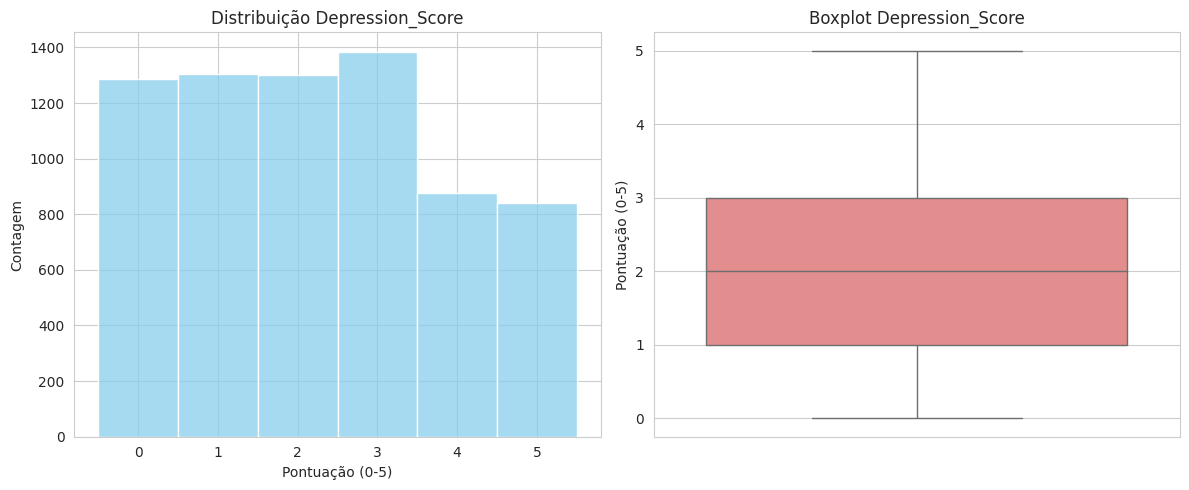


--- Variáveis Preditivas Numéricas (EDA) ---
Estatísticas Descritivas:
|       |   Semester_Credit_Load |   Financial_Stress |        CGPA |
|:------|-----------------------:|-------------------:|------------:|
| count |             6995       |         6995       | 6995        |
| mean  |               22.011   |            2.45347 |    3.49125  |
| std   |                4.36057 |            1.70935 |    0.287363 |
| min   |               15       |            0       |    2.44     |
| 25%   |               18       |            1       |    3.29     |
| 50%   |               22       |            2       |    3.5      |
| 75%   |               26       |            4       |    3.7      |
| max   |               29       |            5       |    4        |


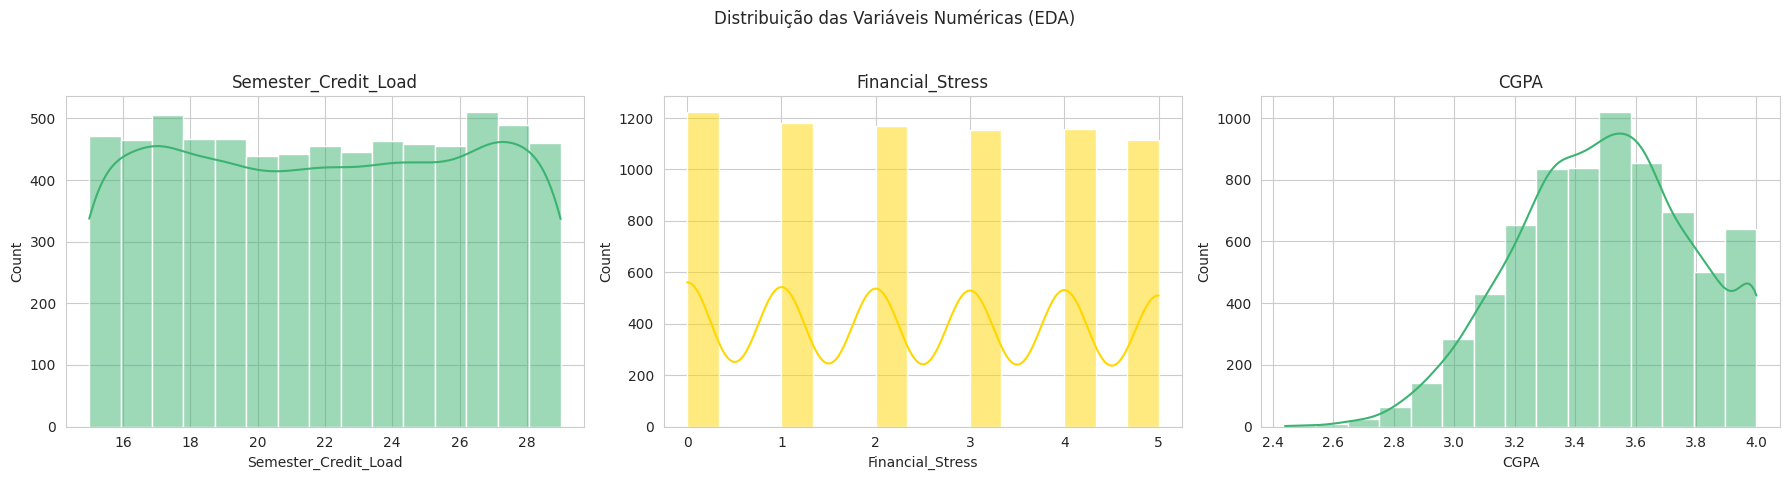


--- Variáveis Preditivas Ordinais (Codificadas) ---
Distribuição (Contagem):


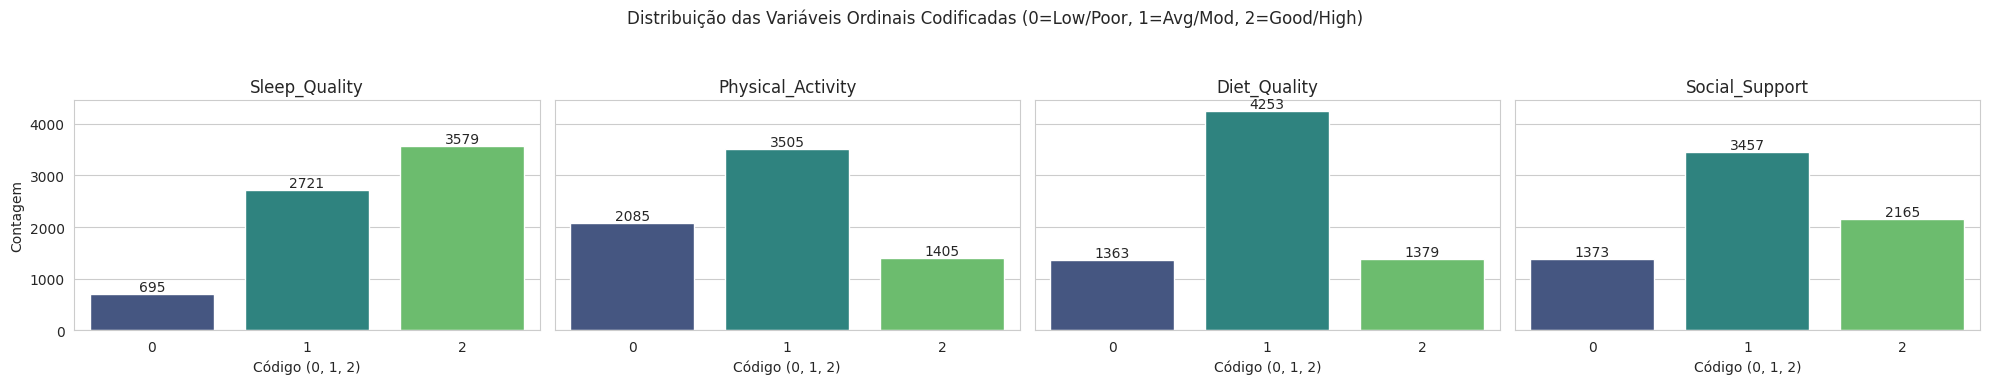


--- Outras Variáveis Categóricas (Distribuição Original) ---


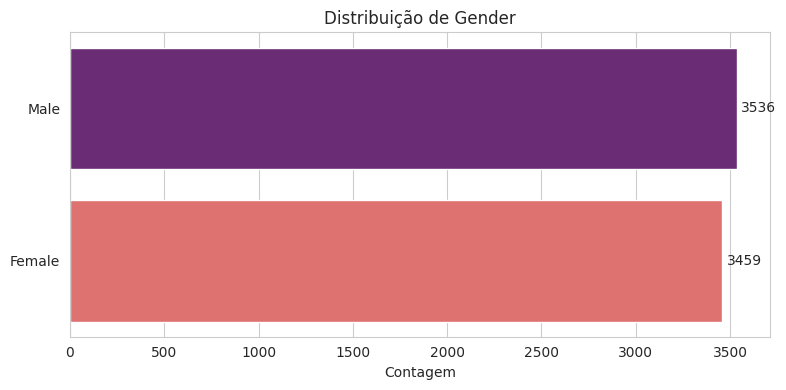

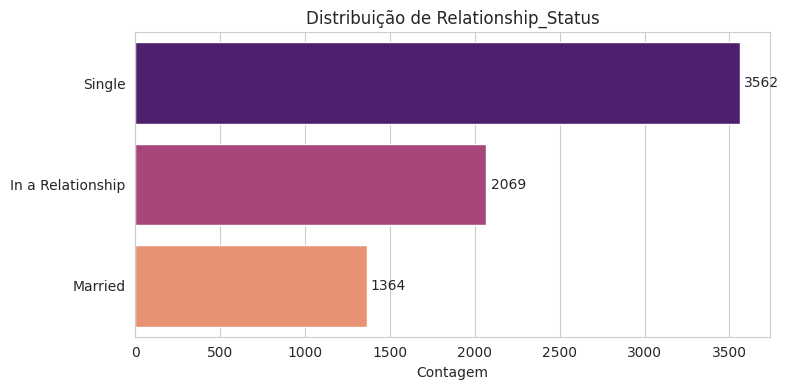

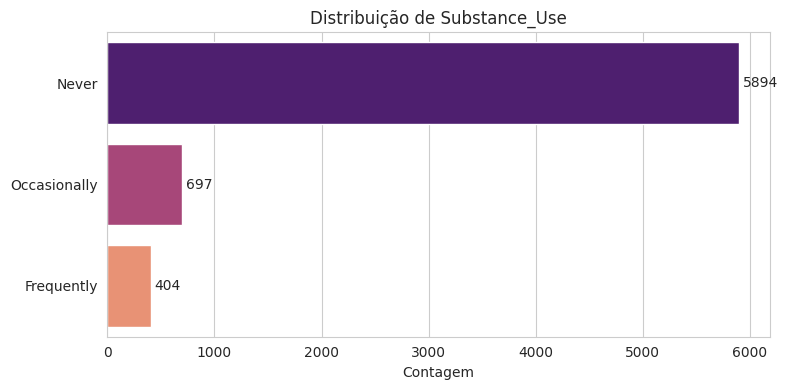

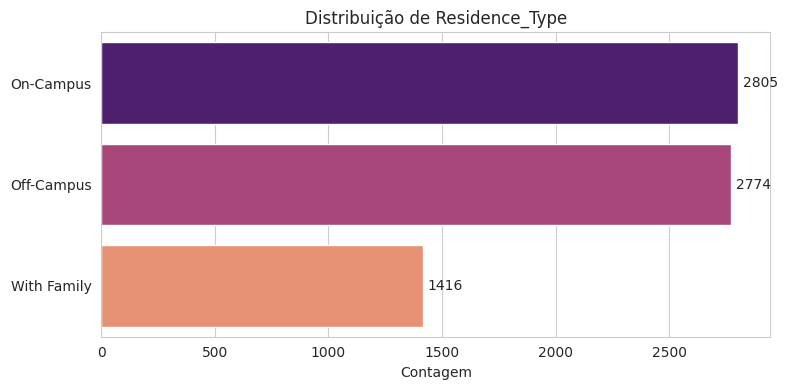

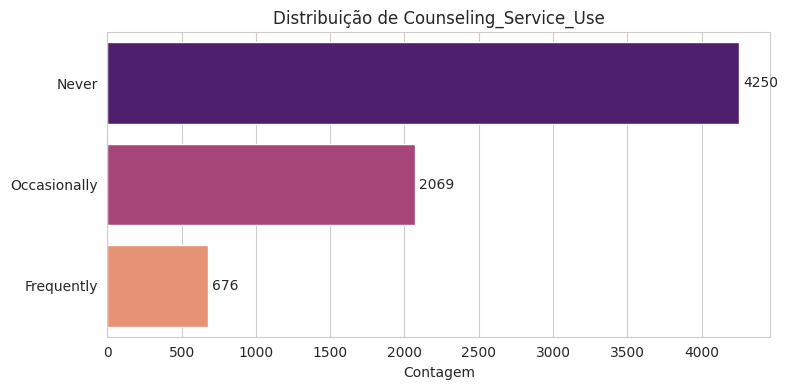

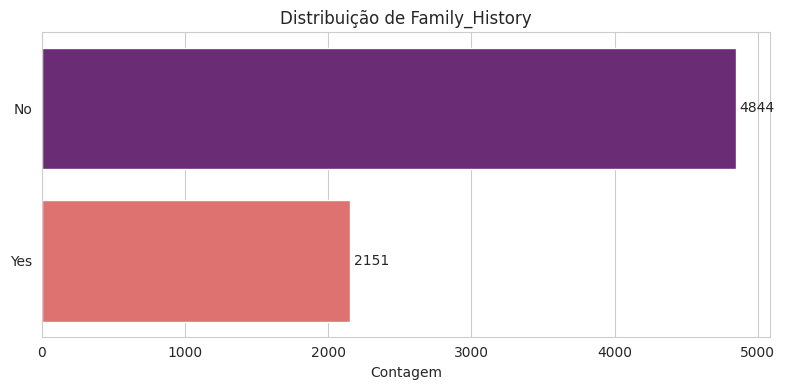

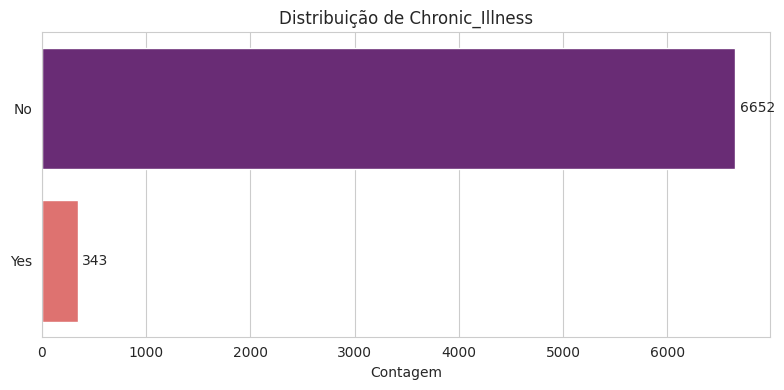

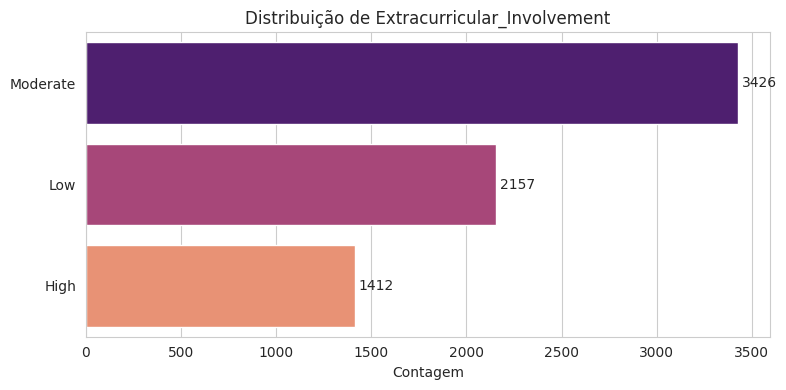

In [50]:
# Variável Alvo: Depression_Score
print("\n--- Variável Alvo: Depression_Score ---")
target_col = 'Depression_Score'
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    print("Estatísticas Descritivas:")
    print(df[target_col].describe().to_markdown())
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=False, bins=df[target_col].nunique(), discrete=True, color='skyblue')
    plt.title(f'Distribuição {target_col}')
    plt.xlabel('Pontuação (0-5)')
    plt.ylabel('Contagem')
    plt.xticks(sorted(df[target_col].unique().astype(int)))

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[target_col], color='lightcoral')
    plt.title(f'Boxplot {target_col}')
    plt.ylabel('Pontuação (0-5)')
    plt.tight_layout(); plt.show()
else:
    print(f"Coluna '{target_col}' não encontrada ou não numérica.")

# Variáveis Preditivas Numéricas
print("\n--- Variáveis Preditivas Numéricas (EDA) ---")
numeric_predictors_eda = ['Semester_Credit_Load', 'Financial_Stress', 'CGPA']
valid_numeric_predictors_eda = [col for col in numeric_predictors_eda if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
if valid_numeric_predictors_eda:
    print("Estatísticas Descritivas:")
    print(df[valid_numeric_predictors_eda].describe().to_markdown())
    n_cols = len(valid_numeric_predictors_eda)
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5))
    if n_cols == 1: axes = [axes]
    fig.suptitle("Distribuição das Variáveis Numéricas (EDA)")
    for i, col in enumerate(valid_numeric_predictors_eda):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=15, color='mediumseagreen' if i%2==0 else 'gold')
        axes[i].set_title(col)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
    print(f"Nenhuma das colunas {numeric_predictors_eda} foi encontrada ou é numérica.")


# Variáveis Preditivas Ordinais (Codificadas)
print("\n--- Variáveis Preditivas Ordinais (Codificadas) ---")
ordinal_predictors = ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support']
valid_ordinal_predictors = [col for col in ordinal_predictors if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
if valid_ordinal_predictors:
    print("Distribuição (Contagem):")
    n_cols = len(valid_ordinal_predictors)
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4), sharey=True)
    if n_cols == 1: axes = [axes]
    fig.suptitle("Distribuição das Variáveis Ordinais Codificadas (0=Low/Poor, 1=Avg/Mod, 2=Good/High)")
    for i, col in enumerate(valid_ordinal_predictors):
        ax = sns.countplot(x=df[col].astype(int), ax=axes[i], palette='viridis', order=sorted(df[col].unique().astype(int)))
        ax.set_title(col)
        ax.set_xlabel("Código (0, 1, 2)")
        ax.set_ylabel("Contagem" if i==0 else "")
        for container in ax.containers:
            ax.bar_label(container)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93]); plt.show()
else:
     print(f"Nenhuma das colunas {ordinal_predictors} foi encontrada ou é numérica.")


# Outras Variáveis Categóricas Originais (Exemplo) - Distribuição
print("\n--- Outras Variáveis Categóricas (Distribuição Original) ---")
other_categorical_cols = ['Gender', 'Relationship_Status', 'Substance_Use', 'Residence_Type',
                          'Counseling_Service_Use', 'Family_History', 'Chronic_Illness',
                          'Extracurricular_Involvement']
for col in other_categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(8, max(4, df[col].nunique()*0.5) ))
        ax = sns.countplot(y=df[col], order = df[col].value_counts().index, palette='magma')
        plt.title(f'Distribuição de {col}')
        plt.xlabel('Contagem')
        plt.ylabel('')
        for container in ax.containers:
           ax.bar_label(container, label_type='edge', padding=3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Aviso: Coluna '{col}' não encontrada.")

### 3.2 Análise Bivariada


--- Depression_Score vs. Variáveis Numéricas (EDA) ---
Correlação entre Depression_Score e Semester_Credit_Load: 0.023 <<--- OBSERVE O SINAL AQUI
Correlação entre Depression_Score e Financial_Stress: -0.012 <<--- OBSERVE O SINAL AQUI
Correlação entre Depression_Score e CGPA: -0.022 <<--- OBSERVE O SINAL AQUI


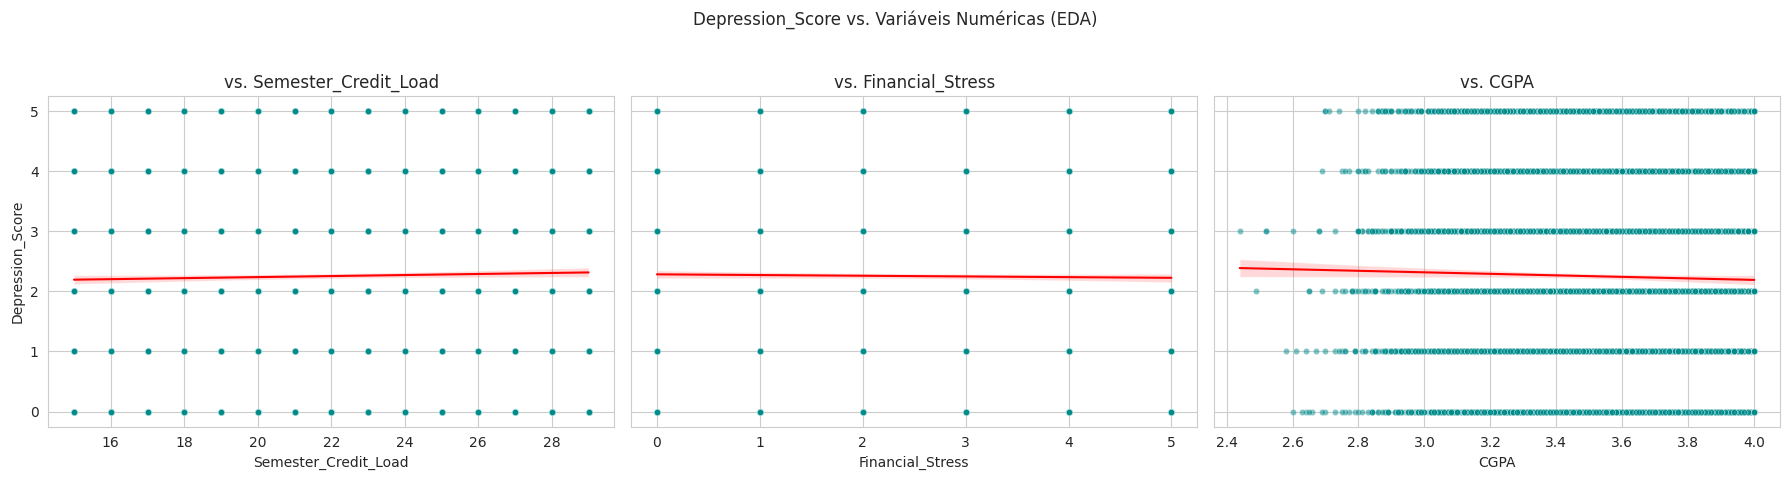


--- Depression_Score vs. Variáveis Ordinais Selecionadas ---
Média Depression_Score por Sleep_Quality:
|   Sleep_Quality |   Depression_Score |
|----------------:|-------------------:|
|               0 |            2.27626 |
|               1 |            2.26314 |
|               2 |            2.24504 |
 <<--- OBSERVE A TENDÊNCIA AQUI
Média Depression_Score por Physical_Activity:
|   Physical_Activity |   Depression_Score |
|--------------------:|-------------------:|
|                   0 |            2.22542 |
|                   1 |            2.26505 |
|                   2 |            2.27473 |
 <<--- OBSERVE A TENDÊNCIA AQUI
Média Depression_Score por Diet_Quality:
|   Diet_Quality |   Depression_Score |
|---------------:|-------------------:|
|              0 |            2.29347 |
|              1 |            2.21444 |
|              2 |            2.343   |
 <<--- OBSERVE A TENDÊNCIA AQUI
Média Depression_Score por Social_Support:
|   Social_Support |   Depression_Score 

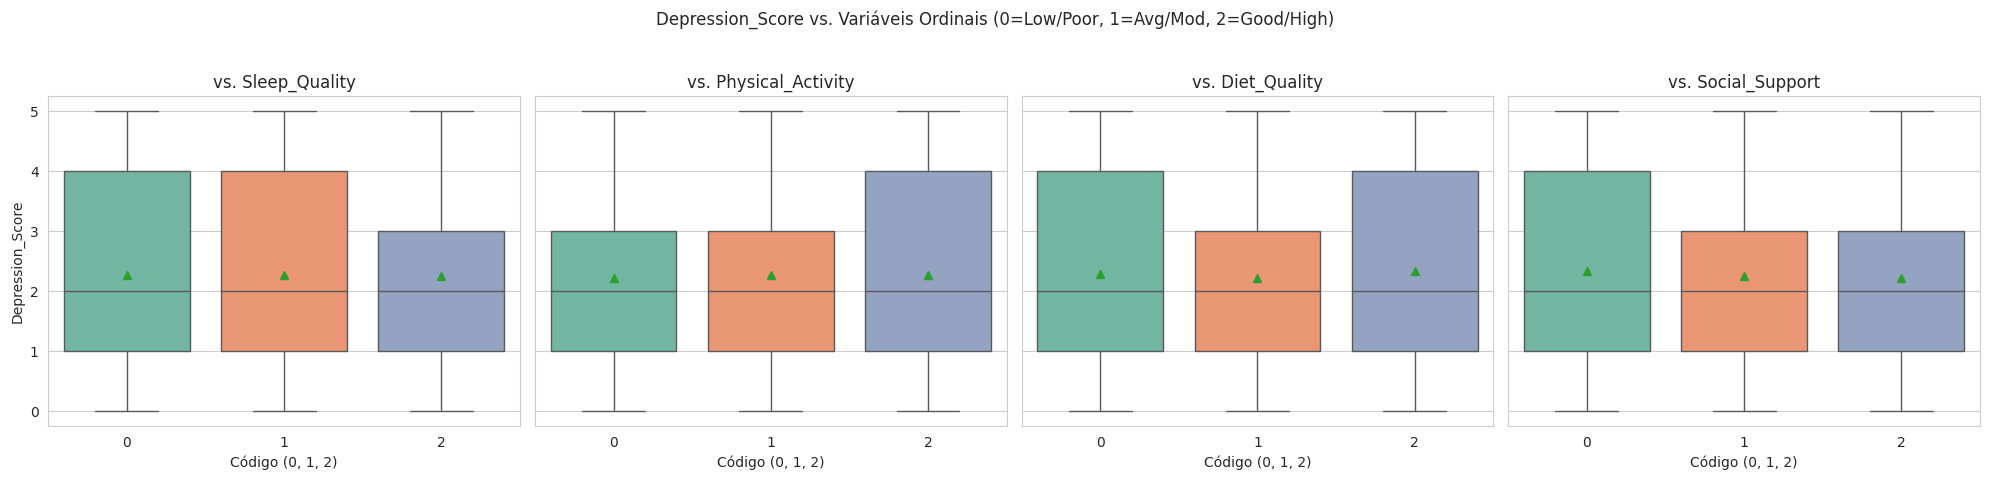


--- Depression_Score vs. Course (Original) ---


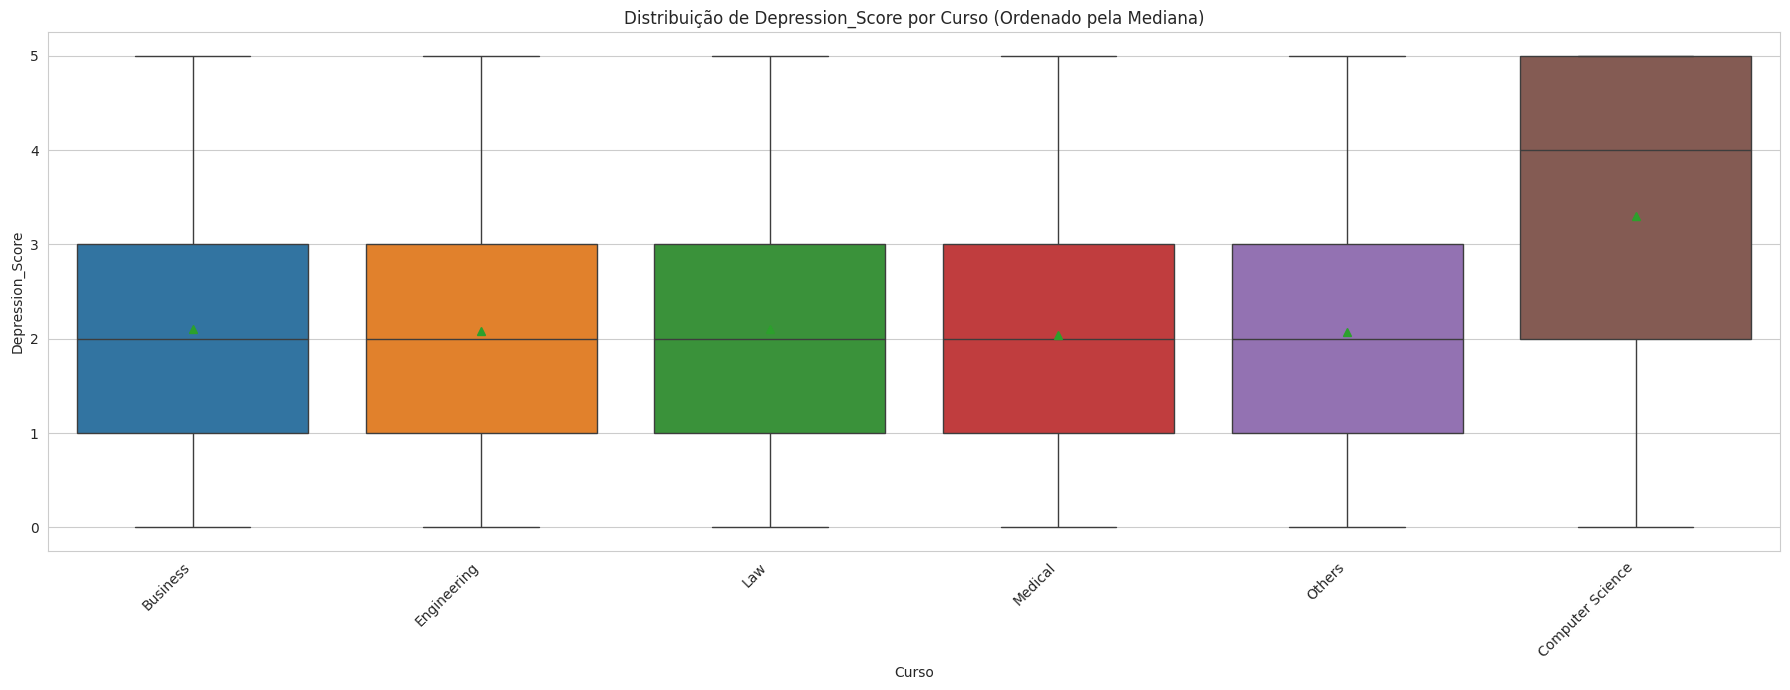


Média, Mediana e Contagem de Depression_Score por Curso (Ordenado pela Média):
| Course           |    mean |   median |   count |
|:-----------------|--------:|---------:|--------:|
| Computer Science | 3.30235 |        4 |    1022 |
| Business         | 2.10629 |        2 |     715 |
| Law              | 2.10065 |        2 |    1381 |
| Engineering      | 2.08622 |        2 |    1067 |
| Others           | 2.07563 |        2 |     714 |
| Medical          | 2.04437 |        2 |    2096 |

--- Matriz de Correlação (Heatmap - EDA) --- 
Calculando correlação (EDA) para as colunas: ['CGPA', 'Depression_Score', 'Diet_Quality', 'Financial_Stress', 'Physical_Activity', 'Semester_Credit_Load', 'Sleep_Quality', 'Social_Support']


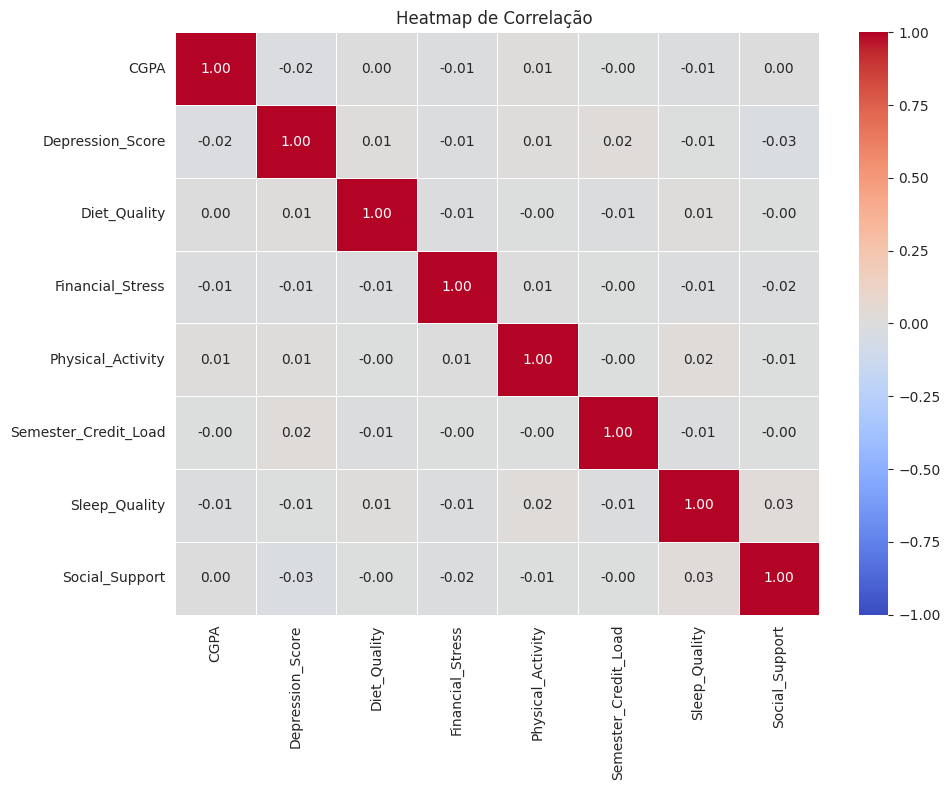

In [51]:
# Alvo vs. Preditores Numéricos
print("\n--- Depression_Score vs. Variáveis Numéricas (EDA) ---")
target_col = 'Depression_Score'
# Usa a lista valid_numeric_predictors_eda definida na célula anterior
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]) and valid_numeric_predictors_eda:
    n_cols = len(valid_numeric_predictors_eda)
    fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 5), sharey=True)
    if n_cols == 1: axes = [axes]
    fig.suptitle(f'{target_col} vs. Variáveis Numéricas (EDA)')
    for i, col in enumerate(valid_numeric_predictors_eda):
        sns.scatterplot(x=df[col], y=df[target_col], alpha=0.5, ax=axes[i], s=20, color='darkcyan')
        sns.regplot(x=df[col], y=df[target_col], scatter=False, color='red', line_kws={'linewidth': 1.5}, ax=axes[i])
        axes[i].set_title(f'vs. {col}')
        axes[i].set_ylabel(target_col if i==0 else '')
        # Calcular correlação de Pearson
        corr_val = df[col].corr(df[target_col])
        print(f"Correlação entre {target_col} e {col}: {corr_val:.3f} <<--- OBSERVE O SINAL AQUI") # Imprime correlação
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
     print(f"Aviso: '{target_col}' ou colunas numéricas (EDA) não encontradas/válidas.")


# Alvo vs. Preditores Ordinais (Codificados)
print("\n--- Depression_Score vs. Variáveis Ordinais Selecionadas ---")
# Reutiliza valid_ordinal_predictors
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]) and valid_ordinal_predictors:
    n_cols = len(valid_ordinal_predictors)
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5), sharey=True)
    if n_cols == 1: axes = [axes]
    fig.suptitle(f'{target_col} vs. Variáveis Ordinais (0=Low/Poor, 1=Avg/Mod, 2=Good/High)')
    for i, col in enumerate(valid_ordinal_predictors):
        sns.boxplot(x=df[col].astype(int), y=df[target_col], ax=axes[i], palette='Set2', showmeans=True)
        axes[i].set_title(f'vs. {col}')
        axes[i].set_xlabel("Código (0, 1, 2)")
        axes[i].set_ylabel(target_col if i==0 else '')
        means = df.groupby(df[col].astype(int))[target_col].mean()
        print(f"Média {target_col} por {col}:\n{means.to_markdown()}\n <<--- OBSERVE A TENDÊNCIA AQUI")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
else:
     print(f"Aviso: '{target_col}' ou colunas ordinais não encontradas/válidas.")


# Alvo vs. Cursos (Usando DataFrame Original)
print("\n--- Depression_Score vs. Course (Original) ---")
try:
    df_orig = pd.read_csv(file_path)
    cols_with_nan_orig = ['CGPA', 'Substance_Use']
    df_orig.dropna(subset=cols_with_nan_orig + ['Course', target_col], inplace=True)

    if not df_orig.empty and 'Course' in df_orig.columns and target_col in df_orig.columns:
      plt.figure(figsize=(18, 7))
      order = df_orig.groupby('Course')[target_col].median().sort_values().index
      sns.boxplot(x='Course', y=target_col, data=df_orig, order=order, palette='tab10', showmeans=True)
      plt.title(f'Distribuição de {target_col} por Curso (Ordenado pela Mediana)')
      plt.xticks(rotation=45, ha='right')
      plt.ylabel(f'{target_col}')
      plt.xlabel('Curso')
      plt.tight_layout()
      plt.show()

      print(f"\nMédia, Mediana e Contagem de {target_col} por Curso (Ordenado pela Média):")
      agg_results = df_orig.groupby('Course')[target_col].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
      print(agg_results.to_markdown())
      del df_orig
    else:
      print("DataFrame original vazio ou colunas 'Course'/'Depression_Score' ausentes após limpeza.")

except FileNotFoundError:
    print("Arquivo original não encontrado para gerar gráfico por curso.")
except Exception as e:
    print(f"Erro ao gerar gráfico por curso original: {e}")


# Correlação entre Variáveis Numéricas e Ordinais Selecionadas
print("\n--- Matriz de Correlação (Heatmap - EDA) --- ")
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    # Usa a lista `valid_numeric_predictors_eda` que inclui CGPA
    cols_for_corr_eda = valid_numeric_predictors_eda + valid_ordinal_predictors + [target_col]
    cols_for_corr_eda = sorted(list(set(cols_for_corr_eda)))
    valid_cols_for_corr_eda = [col for col in cols_for_corr_eda if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    if len(valid_cols_for_corr_eda) > 1:
        print(f"Calculando correlação (EDA) para as colunas: {valid_cols_for_corr_eda}")
        correlation_matrix_eda = df[valid_cols_for_corr_eda].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix_eda, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
        plt.title('Heatmap de Correlação ')
        plt.tight_layout()
        plt.show()
    else:
        print("Não há colunas suficientes encontradas/válidas para gerar heatmap (EDA).")
else:
    print(f"Coluna '{target_col}' não encontrada ou não numérica para correlação (EDA)." )

## 4. Modelagem Inicial: Regressão Linear Múltipla (Com CGPA)


In [52]:
# --- Seleção de Features ---
# Usaremos as listas 'valid_*' da EDA '
feature_cols = valid_ordinal_predictors + valid_numeric_predictors_eda + [col for col in df.columns if col.startswith('Course_')]
target_col = 'Depression_Score'

print(f"\nVariáveis preditoras (Features) selecionadas para o MODELO ({len(feature_cols)}):")
if len(feature_cols) > 10:
    print(f"  {feature_cols[:5]} ... {feature_cols[-5:]}")
else:
    print(f"  {feature_cols}")
print(f"\nVariável Alvo: {target_col}")

# --- Verificações Cruciais ---
if not feature_cols:
    raise ValueError("A lista de features está vazia. Verifique o pré-processamento.")
missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    raise ValueError(f"Features ausentes no DataFrame final: {missing_features}")
if target_col not in df.columns or not pd.api.types.is_numeric_dtype(df[target_col]):
     raise ValueError(f"Variável alvo '{target_col}' ausente ou inválida.")

X = df[feature_cols]
y = df[target_col]




Variáveis preditoras (Features) selecionadas para o MODELO (12):
  ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Semester_Credit_Load'] ... ['Course_Computer Science', 'Course_Engineering', 'Course_Law', 'Course_Medical', 'Course_Others']

Variável Alvo: Depression_Score


In [53]:
# --- 4.2 Divisão Treino/Teste ---
print("\nDividindo dados em treino/teste (80/20, random_state=42)...")
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"  Tamanho Treino: {X_train.shape[0]} amostras ({len(X_train.columns)} features)")
    print(f"  Tamanho Teste:  {X_test.shape[0]} amostras")
except Exception as e:
    print(f"Erro durante a divisão treino/teste: {e}")
    raise SystemExit()




Dividindo dados em treino/teste (80/20, random_state=42)...
  Tamanho Treino: 5596 amostras (12 features)
  Tamanho Teste:  1399 amostras


In [54]:
# --- 4.3 Treinamento do Modelo ---
print("\nTreinando o modelo LinearRegression.")
model = LinearRegression()
try:
    model.fit(X_train, y_train)
    print("  Modelo treinado com sucesso.")
except Exception as e:
    print(f"Erro durante o treinamento: {e}")
    raise SystemExit()


Treinando o modelo LinearRegression.
  Modelo treinado com sucesso.



--- Avaliação do Modelo (Conjunto de Teste) ---
  R² (Coef. de Determinação): 0.0782
  MAE (Erro Absoluto Médio):  1.3020
  MSE (Erro Quadrático Médio): 2.4188
  RMSE (Raiz do EQM):        1.5552

  Interpretação:
    -> R² indica que ~7.8% da variabilidade de 'Depression_Score' é explicada por este modelo.
    -> Em média, o modelo erra a previsão em ~1.30 pontos (MAE) ou ~1.56 pontos (RMSE) na escala 0-5.


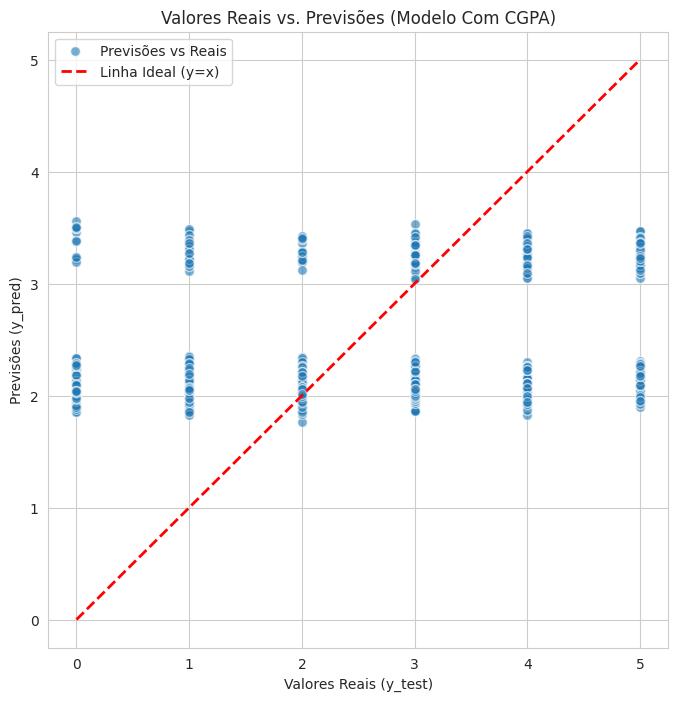

In [55]:
# --- 4.4 Avaliação do Modelo ---
print("\n--- Avaliação do Modelo (Conjunto de Teste) ---")
try:
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"  R² (Coef. de Determinação): {r2:.4f}")
    print(f"  MAE (Erro Absoluto Médio):  {mae:.4f}")
    print(f"  MSE (Erro Quadrático Médio): {mse:.4f}")
    print(f"  RMSE (Raiz do EQM):        {rmse:.4f}")
    print("\n  Interpretação:")
    print(f"    -> R² indica que ~{r2*100:.1f}% da variabilidade de '{target_col}' é explicada por este modelo.")
    print(f"    -> Em média, o modelo erra a previsão em ~{mae:.2f} pontos (MAE) ou ~{rmse:.2f} pontos (RMSE) na escala 0-5.")

    # Gráfico de Previsões vs. Reais
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', s=50, label='Previsões vs Reais')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', lw=2, color='red', label='Linha Ideal (y=x)')
    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Previsões (y_pred)")
    plt.title("Valores Reais vs. Previsões (Modelo Com CGPA)")
    plt.legend()
    plt.grid(True); plt.show()

except Exception as e:
    print(f"Erro durante a avaliação ou plotagem: {e}")




--- Análise dos Coeficientes --- 

Coeficientes (β) do modelo treinado:
| Feature                 |   Coefficient |
|:------------------------|--------------:|
| Intercepto (β0)         |        2.4654 |
| Sleep_Quality           |       -0.002  |
| Physical_Activity       |        0.0073 |
| Diet_Quality            |        0.0378 |
| Social_Support          |       -0.0693 |
| Semester_Credit_Load    |        0.0122 |
| Financial_Stress        |       -0.0275 |
| CGPA                    |       -0.1456 |
| Course_Computer Science |        1.1555 |
| Course_Engineering      |       -0.0441 |
| Course_Law              |        0.0021 |
| Course_Medical          |       -0.0538 |
| Course_Others           |       -0.051  |

<<--- OBSERVE OS SINAIS DOS COEFICIENTES PARA CGPA, Physical_Activity, Diet_Quality AQUI


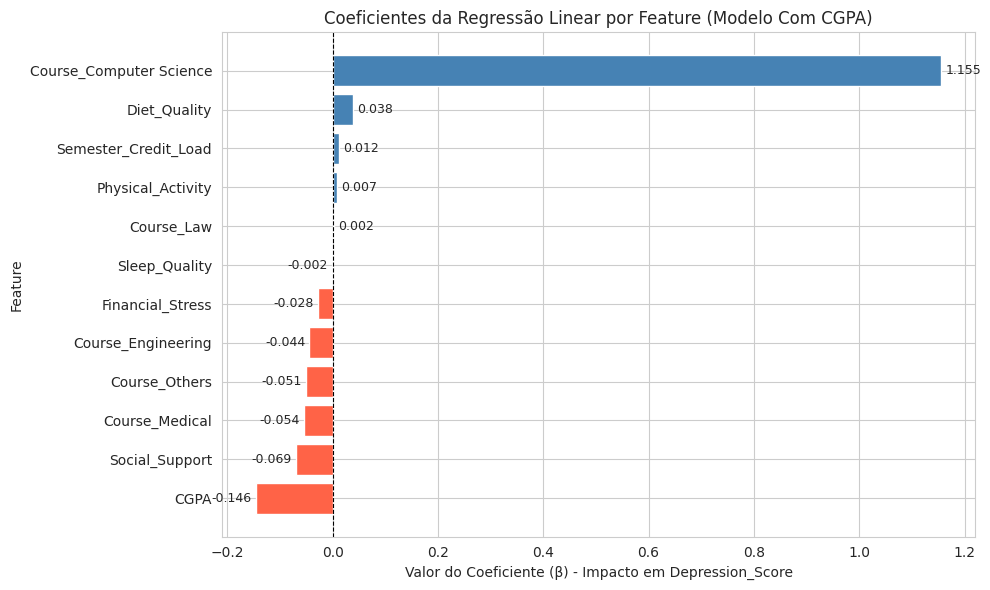


  Interpretação do Gráfico:
    - Barras Azuis (>0): Aumento na feature -> Aumento na previsão de Depressão.
    - Barras Vermelhas (<0): Aumento na feature -> Diminuição na previsão de Depressão.
    -> Verifique os sinais para 'CGPA', 'Physical_Activity' e 'Diet_Quality'. São negativos como esperado?
    - Comprimento da Barra: Magnitude do efeito *nesta escala*.
    - Cuidado: Comparação direta requer padronização prévia.


In [56]:
# --- 4.5 Análise dos Coeficientes ---
print("\n--- Análise dos Coeficientes --- ")
try:
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
    intercept_df = pd.DataFrame({'Feature': ['Intercepto (β0)'], 'Coefficient': [model.intercept_]})
    coefficients = pd.concat([intercept_df, coefficients]).reset_index(drop=True)

    print("\nCoeficientes (β) do modelo treinado:")
    print(coefficients.round(4).to_markdown(index=False))
    print("\n<<--- OBSERVE OS SINAIS DOS COEFICIENTES PARA CGPA, Physical_Activity, Diet_Quality AQUI")

    # Visualização da Magnitude dos Coeficientes (sem intercepto)
    plt.figure(figsize=(10, max(6, len(feature_cols)*0.35)))
    coef_plot_df = coefficients[coefficients['Feature'] != 'Intercepto (β0)'].copy()
    coef_plot_df = coef_plot_df.sort_values(by='Coefficient', ascending=True)
    colors = ['tomato' if c < 0 else 'steelblue' for c in coef_plot_df['Coefficient']]

    bars = plt.barh(coef_plot_df['Feature'], coef_plot_df['Coefficient'], color=colors)
    plt.title('Coeficientes da Regressão Linear por Feature (Modelo Com CGPA)')
    plt.xlabel('Valor do Coeficiente (β) - Impacto em Depression_Score')
    plt.ylabel('Feature')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=9)
    plt.tight_layout(); plt.show()

    print("\n  Interpretação do Gráfico:")
    print("    - Barras Azuis (>0): Aumento na feature -> Aumento na previsão de Depressão.")
    print("    - Barras Vermelhas (<0): Aumento na feature -> Diminuição na previsão de Depressão.")
    print("    -> Verifique os sinais para 'CGPA', 'Physical_Activity' e 'Diet_Quality'. São negativos como esperado?")
    print("    - Comprimento da Barra: Magnitude do efeito *nesta escala*.")
    print("    - Cuidado: Comparação direta requer padronização prévia.")

except Exception as e:
    print(f"Erro ao analisar ou plotar coeficientes: {e}")

#
# SEMANA 3 - REFINAMENTO E VALIDAÇÃO
#
## 5. Validação Cruzada do Modelo Base (Regressão Linear)

Na Semana 2 (Célula 6), treinamos um modelo de Regressão Linear Múltipla usando uma única divisão treino/teste (80/20). O resultado (R², RMSE) obtido é altamente dependente de como essa divisão aleatória foi feita.

Para a Semana 3, começamos estabelecendo um **baseline robusto**. Vamos aplicar a **Validação Cruzada K-Fold (K=10)** ao mesmo modelo de Regressão Linear (com as 8 variáveis selecionadas). Isso treinará e avaliará o modelo 10 vezes em diferentes fatias dos dados, nos dando uma média e um desvio padrão para as métricas. Este será o nosso "resultado oficial" do modelo base.

**Tarefa da Semana 3:** `Validação cruzada` e `Análise de métricas de performance`

In [57]:
# =============================================================================
# CÉLULA 5: CÓDIGO DE VALIDAÇÃO CRUZADA (CV)
# =============================================================================
print("\n--- 5. Validação Cruzada (K=10) do Modelo Base ---")

# Importar ferramentas necessárias para CV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer
import numpy as np

# --- 1. Redefinir X e y (Garantia) ---
# Usando as variáveis da "Proposta Original" (definidas na Célula 4/5)
try:
    # `valid_ordinal_predictors` e `valid_numeric_predictors_eda` foram definidos na Célula 5
    feature_cols = valid_ordinal_predictors + valid_numeric_predictors_eda + [col for col in df.columns if col.startswith('Course_')]
    target_col = 'Depression_Score'

    X = df[feature_cols]
    y = df[target_col]

    print(f"Features (X) e Alvo (y) redefinidos com {len(feature_cols)} colunas de features.")
except NameError:
    print("ERRO: Variáveis 'valid_ordinal_predictors' ou 'valid_numeric_predictors_eda' não encontradas.")
    print("Por favor, execute as Células 3, 4 e 5 primeiro.")
    raise

# --- 2. Definir o Modelo e a Estratégia de CV ---
# O mesmo modelo da Semana 2
model_base = LinearRegression()

# Definir a estratégia de K-Fold (10 fatias, embaralhado)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir as métricas que queremos calcular
scoring_metrics = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error' # RMSE negativo
}

print(f"Iniciando Validação Cruzada (K=10) para {len(feature_cols)} features...")

# --- 3. Executar a Validação Cruzada ---
try:
    cv_results = cross_validate(model_base, X, y, cv=kfold, scoring=scoring_metrics, n_jobs=-1)

    # --- 4. Analisar os Resultados da CV ---
    cv_rmse_scores_base = -cv_results['test_rmse'] # Salva para Célula 11
    cv_r2_scores_base = cv_results['test_r2']     # Salva para Célula 11

    print("\n--- Resultados da Validação Cruzada (10 Folds) ---")
    print(f"Tempo de treino (total): {cv_results['fit_time'].sum():.4f}s")

    print("\n--- Performance do Modelo Base (Baseline Robusto) ---")
    print("Métrica R² (R-quadrado):")
    print(f"  Média R²:   {cv_r2_scores_base.mean():.4f} (+/- {cv_r2_scores_base.std():.4f})")
    print(f"  (Valores por fold: {np.round(cv_r2_scores_base, 3)})")

    print("\nMétrica RMSE (Root Mean Squared Error):")
    print(f"  Média RMSE:   {cv_rmse_scores_base.mean():.4f} (+/- {cv_rmse_scores_base.std():.4f})")
    print(f"  (Valores por fold: {np.round(cv_rmse_scores_base, 3)})")

    print("\nInterpretação do Baseline:")
    print(f"  Em média, nosso modelo base (Proposta Original) explica ~{cv_r2_scores_base.mean()*100:.1f}% da variância (R²). ")
    print(f"  Em média, nosso modelo base erra ~{cv_rmse_scores_base.mean():.2f} pontos (RMSE) na escala 0-5.")

except Exception as e:
    print(f"\nERRO durante a validação cruzada: {e}")



--- 5. Validação Cruzada (K=10) do Modelo Base ---
Features (X) e Alvo (y) redefinidos com 12 colunas de features.
Iniciando Validação Cruzada (K=10) para 12 features...

--- Resultados da Validação Cruzada (10 Folds) ---
Tempo de treino (total): 0.0727s

--- Performance do Modelo Base (Baseline Robusto) ---
Métrica R² (R-quadrado):
  Média R²:   0.0682 (+/- 0.0194)
  (Valores por fold: [0.098 0.05  0.083 0.057 0.082 0.045 0.048 0.06  0.06  0.099])

Métrica RMSE (Root Mean Squared Error):
  Média RMSE:   1.5672 (+/- 0.0303)
  (Valores por fold: [1.575 1.536 1.566 1.611 1.52  1.589 1.57  1.588 1.597 1.521])

Interpretação do Baseline:
  Em média, nosso modelo base (Proposta Original) explica ~6.8% da variância (R²). 
  Em média, nosso modelo base erra ~1.57 pontos (RMSE) na escala 0-5.


# 6. Padronização de Features (StandardScaler) com Pipeline
#

**Tarefa da Semana 3:** `Refinamento` (Preparação)

Nossas features numéricas (`CGPA`, `Financial_Stress`, `Semester_Credit_Load`) estão em escalas diferentes. Isso é crucial para os modelos de regularização (Lasso, Ridge) que testaremos a seguir.

Usaremos um **`ColumnTransformer`** para aplicar `StandardScaler` (Padronização Z-score) **apenas** nas colunas numéricas e deixar as outras (ordinais e one-hot) intactas.

Vamos re-rodar a Validação Cruzada neste novo pipeline. O R² e o RMSE devem ser **idênticos** aos da Célula 7, provando que o processo está correto.

In [58]:
# =============================================================================
# CÉLULA 6: CÓDIGO - PADRONIZAÇÃO COM PIPELINE E COLUMNTRANSFORMER
# =============================================================================
print("\n--- 6. Padronização de Features com Pipeline ---")

# Importar ferramentas necessárias
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# --- 1. Definir Colunas para Transformação ---
# Usando a lista 'valid_numeric_predictors_eda' da Célula 5 (que inclui CGPA)
try:
    numeric_features_to_scale = valid_numeric_predictors_eda
    print(f"Colunas a serem padronizadas: {numeric_features_to_scale}")

    # 'passthrough_features' são todas as colunas em X que NÃO são numéricas
    passthrough_features = [col for col in X.columns if col not in numeric_features_to_scale]
    print(f"{len(passthrough_features)} colunas passarão sem alteração (passthrough). (Ex: {passthrough_features[:3]}...)")
except NameError:
    print("ERRO: 'valid_numeric_predictors_eda' não definida. Rode a Célula 5 primeiro.")
    raise

# --- 2. Criar o Pré-processador ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('scale_numeric', StandardScaler(), numeric_features_to_scale)
    ],
    remainder='passthrough' # Deixa as colunas ordinais e one-hot intactas
)

# --- 3. Criar o Pipeline Completo ---
# O pipeline primeiro executa o 'preprocessor', depois treina o 'model'
pipeline_lr_scaled = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# --- 4. Executar Validação Cruzada no Pipeline ---
print("\nIniciando Validação Cruzada (K=10) no *Pipeline Padronizado*...")

try:
    cv_results_scaled = cross_validate(pipeline_lr_scaled, X, y, cv=kfold, scoring=scoring_metrics, n_jobs=-1)

    # --- 5. Analisar os Resultados da CV (Padronizado) ---
    cv_rmse_scores_scaled = -cv_results_scaled['test_rmse']
    cv_r2_scores_scaled = cv_results_scaled['test_r2']

    print("\n--- Resultados da CV (Modelo Padronizado) ---")
    print(f"  Média R²:   {cv_r2_scores_scaled.mean():.4f} (+/- {cv_r2_scores_scaled.std():.4f})")
    print(f"  Média RMSE: {cv_rmse_scores_scaled.mean():.4f} (+/- {cv_rmse_scores_scaled.std():.4f})")

    print("\nInterpretação da Célula 8:")
    print("  -> Resultados R²/RMSE idênticos aos da Célula 7 (Regressão Linear não é sensível à escala).")
    print("  -> Pipeline de pré-processamento validado. Pronto para Lasso e Ridge.")

except Exception as e:
    print(f"\nERRO durante a validação cruzada do pipeline: {e}")



--- 6. Padronização de Features com Pipeline ---
Colunas a serem padronizadas: ['Semester_Credit_Load', 'Financial_Stress', 'CGPA']
9 colunas passarão sem alteração (passthrough). (Ex: ['Sleep_Quality', 'Physical_Activity', 'Diet_Quality']...)

Iniciando Validação Cruzada (K=10) no *Pipeline Padronizado*...

--- Resultados da CV (Modelo Padronizado) ---
  Média R²:   0.0682 (+/- 0.0194)
  Média RMSE: 1.5672 (+/- 0.0303)

Interpretação da Célula 8:
  -> Resultados R²/RMSE idênticos aos da Célula 7 (Regressão Linear não é sensível à escala).
  -> Pipeline de pré-processamento validado. Pronto para Lasso e Ridge.


# 7. Otimização de Hiperparâmetros: Regressão Lasso (L1) e Ridge (L2)
#

Agora vamos tentar melhorar o modelo base. Usaremos **Lasso (L1)** e **Ridge (L2)**, que são Regressões Lineares com **regularização** para penalizar coeficientes muito grandes.

* **Lasso (L1):** Pode **zerar completamente** os coeficientes de features inúteis (Seleção Automática de Features).
* **Ridge (L2):** Encolhe coeficientes grandes (bom para multicolinearidade).

Usaremos **`GridSearchCV`** para encontrar o melhor hiperparâmetro `alpha` (força da regularização) para cada um, reutilizando o `preprocessor` (com `StandardScaler`) da Célula 8.

In [59]:
# =============================================================================
# CÉLULA 7: CÓDIGO - GridSearchCV para Lasso e Ridge
# =============================================================================
print("\n--- 7. Otimização de Hiperparâmetros (Lasso e Ridge) ---")

# Importar modelos de Regularização e GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

# --- 1. Recuperar Inputs (das células anteriores) ---
if 'X' not in locals() or 'y' not in locals() or 'kfold' not in locals() or 'preprocessor' not in locals() or 'scoring_metrics' not in locals():
    print("ERRO: Variáveis essenciais (X, y, kfold, preprocessor, scoring_metrics) não definidas. Rode as células anteriores.")
    raise SystemExit()

# --- 2. Otimização do Modelo Lasso (L1) ---
print("\n--- Otimizando Modelo Lasso (L1) ---")

pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(random_state=42, max_iter=10000))
])

# Grade de 'alphas' para o Lasso testar
param_grid_lasso = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
}

grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=kfold,
                        scoring=scoring_metrics, refit='r2', n_jobs=-1)

print("  Rodando GridSearchCV para Lasso...")
grid_lasso.fit(X, y)
print("  Otimização Lasso concluída.")

# --- 3. Resultados do Lasso ---
print("\n--- Resultados do Lasso (L1) ---")
print(f"Melhor Alpha: {grid_lasso.best_params_}")
best_index_lasso = grid_lasso.best_index_
best_r2_lasso = grid_lasso.cv_results_['mean_test_r2'][best_index_lasso]
best_rmse_lasso = -grid_lasso.cv_results_['mean_test_rmse'][best_index_lasso]
print(f"  Melhor R² Médio (CV):   {best_r2_lasso:.4f}")
print(f"  Melhor RMSE Médio (CV): {best_rmse_lasso:.4f}")

# --- 4. Otimização do Modelo Ridge (L2) ---
print("\n--- Otimizando Modelo Ridge (L2) ---")

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=42))
])
param_grid_ridge = {
    'model__alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 200.0]
}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=kfold,
                        scoring=scoring_metrics, refit='r2', n_jobs=-1)

print("  Rodando GridSearchCV para Ridge...")
grid_ridge.fit(X, y)
print("  Otimização Ridge concluída.")

# --- 5. Resultados do Ridge ---
print("\n--- Resultados do Ridge (L2) ---")
print(f"Melhor Alpha: {grid_ridge.best_params_}")
best_index_ridge = grid_ridge.best_index_
best_r2_ridge = grid_ridge.cv_results_['mean_test_r2'][best_index_ridge]
best_rmse_ridge = -grid_ridge.cv_results_['mean_test_rmse'][best_index_ridge]
print(f"  Melhor R² Médio (CV):   {best_r2_ridge:.4f}")
print(f"  Melhor RMSE Médio (CV): {best_rmse_ridge:.4f}")

# --- 6. Análise de Coeficientes (Feature Selection do Lasso) ---
print("\n--- Análise de Coeficientes do Melhor Modelo Lasso ---")

best_lasso_model = grid_lasso.best_estimator_
lasso_coefficients = best_lasso_model.named_steps['model'].coef_

# Recuperar os nomes das features DEPOIS do ColumnTransformer
try:
    feature_names_transformed = best_lasso_model.named_steps['preprocessor'].get_feature_names_out()
except Exception as e:
    print(f"Aviso: get_feature_names_out falhou ({e}). Usando lista de colunas X.")
    feature_names_transformed = X.columns # Fallback

coef_df = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Coefficient': lasso_coefficients
})

zero_coef_features = coef_df[np.isclose(coef_df['Coefficient'], 0)]
non_zero_coef_features = coef_df[~np.isclose(coef_df['Coefficient'], 0)]

print(f"O Lasso (alpha={grid_lasso.best_params_['model__alpha']}) manteve {len(non_zero_coef_features)} features.")
print(f"O Lasso ZEROU {len(zero_coef_features)} features (considerou-as inúteis).")

print("\nCoeficientes NÃO-ZEROS do Lasso (Ordenados por magnitude):")
non_zero_coef_features['Abs_Coefficient'] = non_zero_coef_features['Coefficient'].abs()
print(non_zero_coef_features.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1).round(4).to_markdown(index=False))


--- 7. Otimização de Hiperparâmetros (Lasso e Ridge) ---

--- Otimizando Modelo Lasso (L1) ---
  Rodando GridSearchCV para Lasso...
  Otimização Lasso concluída.

--- Resultados do Lasso (L1) ---
Melhor Alpha: {'model__alpha': 0.01}
  Melhor R² Médio (CV):   0.0689
  Melhor RMSE Médio (CV): 1.5666

--- Otimizando Modelo Ridge (L2) ---
  Rodando GridSearchCV para Ridge...
  Otimização Ridge concluída.

--- Resultados do Ridge (L2) ---
Melhor Alpha: {'model__alpha': 10.0}
  Melhor R² Médio (CV):   0.0682
  Melhor RMSE Médio (CV): 1.5672

--- Análise de Coeficientes do Melhor Modelo Lasso ---
O Lasso (alpha=0.01) manteve 7 features.
O Lasso ZEROU 5 features (considerou-as inúteis).

Coeficientes NÃO-ZEROS do Lasso (Ordenados por magnitude):
| Feature                             |   Coefficient |
|:------------------------------------|--------------:|
| remainder__Course_Computer Science  |        1.1419 |
| scale_numeric__Semester_Credit_Load |        0.029  |
| scale_numeric__CGPA      

# 8. Testes Estatísticos (Statsmodels OLS)
#
**Tarefa da Semana 3:** `Testes estatísticos`

Queremos saber se o impacto das nossas variáveis (como `CGPA`, `Sleep_Quality`) é **estatisticamente significante** (p-value < 0.05). Para isso, usamos a biblioteca `statsmodels` nos dados padronizados.

Vamos verificar nossas hipóteses:
1.  `CGPA` tem impacto negativo?
2.  `Physical_Activity` tem impacto negativo?
3.  `Diet_Quality` tem impacto negativo?

In [60]:
# =============================================================================
# CÉLULA 8: CÓDIGO - STATSMODELS OLS PARA P-VALUES
# =============================================================================
print("\n--- 8. Testes Estatísticos com Statsmodels OLS ---")

# Importar a biblioteca statsmodels
import statsmodels.api as sm

# --- 1. Preparar os Dados para o Statsmodels ---
print("Preparando dados padronizados para statsmodels...")

if 'X' not in locals() or 'y' not in locals() or 'preprocessor' not in locals():
    print("ERRO: Variáveis X, y ou preprocessor não definidas. Rode as células anteriores.")
    raise SystemExit()

# 1.1. Aplicar o preprocessor (padronização) aos dados X
try:
    X_scaled = preprocessor.fit_transform(X)
except Exception as e:
    print(f"Erro ao aplicar preprocessor: {e}")
    raise SystemExit()

# 1.2. Recuperar os nomes das colunas após o ColumnTransformer
try:
    feature_names_scaled = preprocessor.get_feature_names_out()
except Exception as e:
    print(f"Aviso: get_feature_names_out falhou ({e}). Montando nomes manualmente.")
    # Fallback (ordem deve ser a mesma do ColumnTransformer)
    numeric_feature_names = [f"scale_numeric__{col}" for col in numeric_features_to_scale] # da Célula 8
    passthrough_feature_names = [f"remainder__{col}" for col in passthrough_features] # da Célula 8
    feature_names_scaled = numeric_feature_names + passthrough_feature_names

# Converter de volta para um DataFrame do Pandas
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names_scaled, index=y.index)

# 1.3. Adicionar a Constante (Intercepto)
X_with_const = sm.add_constant(X_scaled_df, prepend=True)
print("  Dados padronizados e constante (intercepto) adicionada.")


# --- 2. Treinar o Modelo OLS ---
print("\nTreinando modelo OLS (Ordinary Least Squares)...")
try:
    model_sm = sm.OLS(y, X_with_const)
    results_sm = model_sm.fit()
    print("  Modelo OLS treinado com sucesso.")
except Exception as e:
    print(f"Erro ao treinar modelo OLS: {e}")
    raise SystemExit()

# --- 3. Exibir o Relatório Completo ---
print("\n" + "="*80)
print("           Resultados Completos da Regressão (Statsmodels OLS)")
print("="*80)
print(results_sm.summary())

# --- 4. Interpretação dos Resultados ---
print("\n" + "="*80)
print("Interpretação da Tabela (Statsmodels):")
print(f"  R-squared (R²):           {results_sm.rsquared:.4f}")
print(f"  Adj. R-squared (R² Ajust.): {results_sm.rsquared_adj:.4f}")
print("\nFoco Principal - Coeficientes e P-Values (`P>|t|`):")
print("  -> 'coef': Impacto da feature (padronizada).")
print("  -> 'P>|t|' (p-value): Se < 0.05, a feature é ESTATISTICAMENTE SIGNIFICANTE.")

# Extrair p-values
pvalues = results_sm.pvalues.drop('const') # Ignora o intercepto
significantes = pvalues[pvalues < 0.05]
nao_significantes = pvalues[pvalues >= 0.05]

print("\n--- Sumário de Significância (p < 0.05) ---")
if not significantes.empty:
    print("✅ Variáveis ESTATISTICAMENTE SIGNIFICANTES (P < 0.05):")
    print(significantes.sort_values().to_markdown())
else:
    print("(!) Nenhuma variável foi estatisticamente significante.")

if not nao_significantes.empty:
    print("\n❌ Variáveis NÃO SIGNIFICANTES (P >= 0.05) (Candidatas à remoção):")
    print(nao_significantes.sort_values(ascending=False).to_markdown())
else:
    print("(!) Todas as variáveis foram significantes.")

# --- 5. Verificação das Hipóteses ---
print("\n--- Verificação das Hipóteses Iniciais (P < 0.05?) ---")
try:
    # Ajusta os nomes das features para como o preprocessor os renomeou
    cgpa_col_name = [col for col in feature_names_scaled if 'CGPA' in col][0]
    activity_col_name = [col for col in feature_names_scaled if 'Physical_Activity' in col][0]
    diet_col_name = [col for col in feature_names_scaled if 'Diet_Quality' in col][0]

    print(f"  Hipótese CGPA (esperado: < 0): Coef = {results_sm.params[cgpa_col_name]:.3f}, P-value = {results_sm.pvalues[cgpa_col_name]:.3f}")
    print(f"  Hipótese Physical_Activity (esperado: < 0): Coef = {results_sm.params[activity_col_name]:.3f}, P-value = {results_sm.pvalues[activity_col_name]:.3f}")
    print(f"  Hipótese Diet_Quality (esperado: < 0): Coef = {results_sm.params[diet_col_name]:.3f}, P-value = {results_sm.pvalues[diet_col_name]:.3f}")
except IndexError:
    print("ERRO: Não foi possível encontrar os nomes das colunas 'CGPA', 'Physical_Activity' ou 'Diet_Quality' nos resultados do preprocessor.")
except KeyError:
    print("ERRO: Nomes das colunas não encontrados nos resultados do Statsmodels.")



--- 8. Testes Estatísticos com Statsmodels OLS ---
Preparando dados padronizados para statsmodels...
  Dados padronizados e constante (intercepto) adicionada.

Treinando modelo OLS (Ordinary Least Squares)...
  Modelo OLS treinado com sucesso.

           Resultados Completos da Regressão (Statsmodels OLS)
                            OLS Regression Results                            
Dep. Variable:       Depression_Score   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     46.02
Date:                Mon, 10 Nov 2025   Prob (F-statistic):          3.54e-106
Time:                        05:56:39   Log-Likelihood:                -13054.
No. Observations:                6995   AIC:                         2.613e+04
Df Residuals:                    6982   BIC:                         2.622e+04
Df Model:                          12                      


# 9. Otimização de Hiperparâmetros: Modelo Não-Linear (RandomForestRegressor)
#
Modelos lineares (como os anteriores) são bons, mas podem não capturar relações complexas. Vamos testar um modelo **não-linear**: o `RandomForestRegressor`.

Usaremos **`RandomizedSearchCV`** (versão RÁPIDA: `n_iter=10`, `cv=5`) para otimizar seus hiperparâmetros. Este modelo **não** precisa dos dados padronizados (usamos `X` e `y` originais) e nos dará a **Importância das Features**.


--- 9. Otimização de Hiperparâmetros (RandomForestRegressor) ---
Treinando em 6995 amostras e 12 features.

Iniciando RandomizedSearch (n_iter=10, cv=5)...
  Otimização do Random Forest concluída.

--- Resultados do Melhor Modelo Random Forest ---
Melhores Hiperparâmetros: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 139}
  Melhor R² Médio (CV):   0.0565
  Melhor RMSE Médio (CV): 1.5780

Comparação com Baseline (Regressão Linear da Célula 7):
  R² Base (Reg. Linear): 0.0682 (de K=10)
  RMSE Base (Reg. Linear): 1.5672 (de K=10)

  Melhoria R² (RF vs Base): -0.0117
  Melhoria RMSE (RF vs Base): +0.0108 (Negativo é melhor)
  -> Análise: O Random Forest NÃO foi significativamente melhor que a Regressão Linear.

--- Análise de Importância das Features (Random Forest) ---
Importância das Features (Quais features o modelo mais usou):
| Feature                 |   Importance |
|:------------------------|-------------:|
| Course_Comp

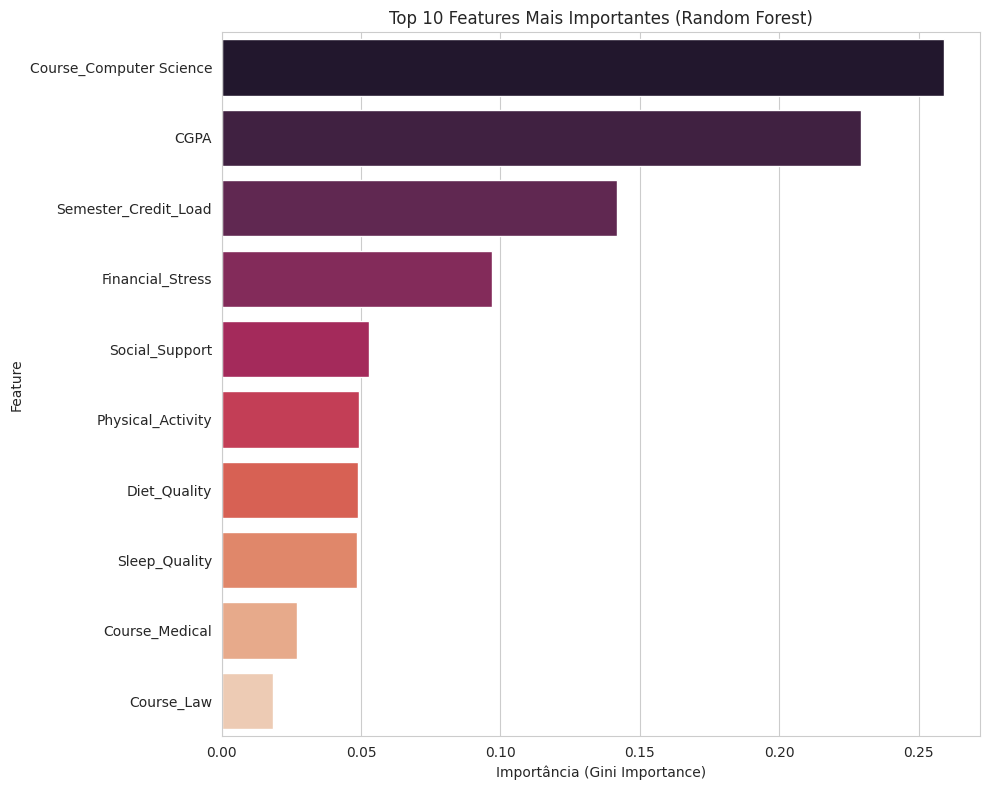

In [61]:
# =============================================================================
# CÉLULA 9: CÓDIGO - RandomizedSearchCV para RandomForestRegressor (VERSÃO RÁPIDA)
# =============================================================================
print("\n--- 9. Otimização de Hiperparâmetros (RandomForestRegressor) ---")

# Importar o modelo e o RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# --- 1. Recuperar Inputs (das células anteriores) ---
if 'X' not in locals() or 'y' not in locals():
    print("ERRO: Variáveis X e y não definidas. Rode as células anteriores.")
    raise SystemExit()
# Vamos usar 5 folds aqui para ser mais rápido
kfold_rapido = KFold(n_splits=5, shuffle=True, random_state=42)
if 'scoring_metrics' not in locals():
    scoring_metrics = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

print(f"Treinando em {X.shape[0]} amostras e {X.shape[1]} features.")

# --- 2. Definir o Modelo e a Grade de Hiperparâmetros (Distribuição RÁPIDA) ---
rf_model = RandomForestRegressor(random_state=42)

param_dist_rf_rapida = {
    'n_estimators': randint(low=50, high=250),     # Nº de árvores (Reduzido)
    'max_depth': [10, 20, None],                   # Profundidade máxima
    'min_samples_leaf': randint(low=1, high=5),    # Mínimo de amostras por folha
    'min_samples_split': randint(low=2, high=11),  # Mínimo para dividir um nó
    'max_features': ['sqrt', 'log2', 1.0]          # Features a considerar
}

# --- 3. Configurar e Executar o RandomizedSearchCV (RÁPIDO) ---
print("\nIniciando RandomizedSearch (n_iter=10, cv=5)...")
# n_iter=10 -> Testa SÓ 10 combinações aleatórias
# cv=5 -> Usa 5 folds
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf_rapida,
    n_iter=10, # <-- RÁPIDO
    cv=kfold_rapido, # <-- RÁPIDO
    scoring=scoring_metrics,
    refit='r2',
    n_jobs=-1,
    random_state=42
)

try:
    rf_random_search.fit(X, y)
    print("  Otimização do Random Forest concluída.")
except Exception as e:
    print(f"Erro durante o RandomizedSearch: {e}")
    raise SystemExit()

# --- 4. Resultados do Random Forest ---
print("\n--- Resultados do Melhor Modelo Random Forest ---")
print(f"Melhores Hiperparâmetros: {rf_random_search.best_params_}")

best_index_rf = rf_random_search.best_index_
best_r2_rf = rf_random_search.cv_results_['mean_test_r2'][best_index_rf]
best_rmse_rf = -rf_random_search.cv_results_['mean_test_rmse'][best_index_rf]

print(f"  Melhor R² Médio (CV):   {best_r2_rf:.4f}")
print(f"  Melhor RMSE Médio (CV): {best_rmse_rf:.4f}")

# --- 5. Comparação com o Baseline (Regressão Linear) ---
print("\nComparação com Baseline (Regressão Linear da Célula 7):")
try:
    print(f"  R² Base (Reg. Linear): {cv_r2_scores_base.mean():.4f} (de K=10)")
    print(f"  RMSE Base (Reg. Linear): {cv_rmse_scores_base.mean():.4f} (de K=10)")

    r2_diff = best_r2_rf - cv_r2_scores_base.mean()
    rmse_diff = best_rmse_rf - cv_rmse_scores_base.mean()

    print(f"\n  Melhoria R² (RF vs Base): {r2_diff:+.4f}")
    print(f"  Melhoria RMSE (RF vs Base): {rmse_diff:+.4f} (Negativo é melhor)")
    if r2_diff > 0.01 and rmse_diff < -0.01:
        print("  -> Análise: O Random Forest foi visivelmente MELHOR que a Regressão Linear.")
    else:
        print("  -> Análise: O Random Forest NÃO foi significativamente melhor que a Regressão Linear.")
except NameError:
    print("  (Resultados da Célula 7 'cv_r2_scores_base' não encontrados. Execute-a para comparar.)")

# --- 6. Análise de Importância das Features (Random Forest) ---
print("\n--- Análise de Importância das Features (Random Forest) ---")

try:
    best_rf_model = rf_random_search.best_estimator_
    feature_importances = best_rf_model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("Importância das Features (Quais features o modelo mais usou):")
    print(importance_df.head(10).to_markdown(index=False, floatfmt=".4f")) # Top 10

    # Plotar as importâncias
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='rocket')
    plt.title('Top 10 Features Mais Importantes (Random Forest)')
    plt.xlabel('Importância (Gini Importance)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erro ao calcular ou plotar importância das features: {e}")


# 10. Análise de Métricas: Análise de Resíduos (Diagnóstico do Modelo)
#

Etapa final de diagnóstico. Vamos analisar os **resíduos** (erros = Real - Previsto) do nosso *melhor* modelo (o que teve melhor R²/RMSE) para ver se há padrões.


--- 10. Análise de Resíduos do Melhor Modelo ---
Analisando resíduos do melhor modelo: Lasso (R²: 0.0689)
Gerando previsões com 'cross_val_predict'...
Resíduos calculados (Valor Real - Valor Previsto).

Plotando Gráfico 1: Resíduos vs. Valores Previstos...
Plotando Gráfico 2: Histograma dos Resíduos...


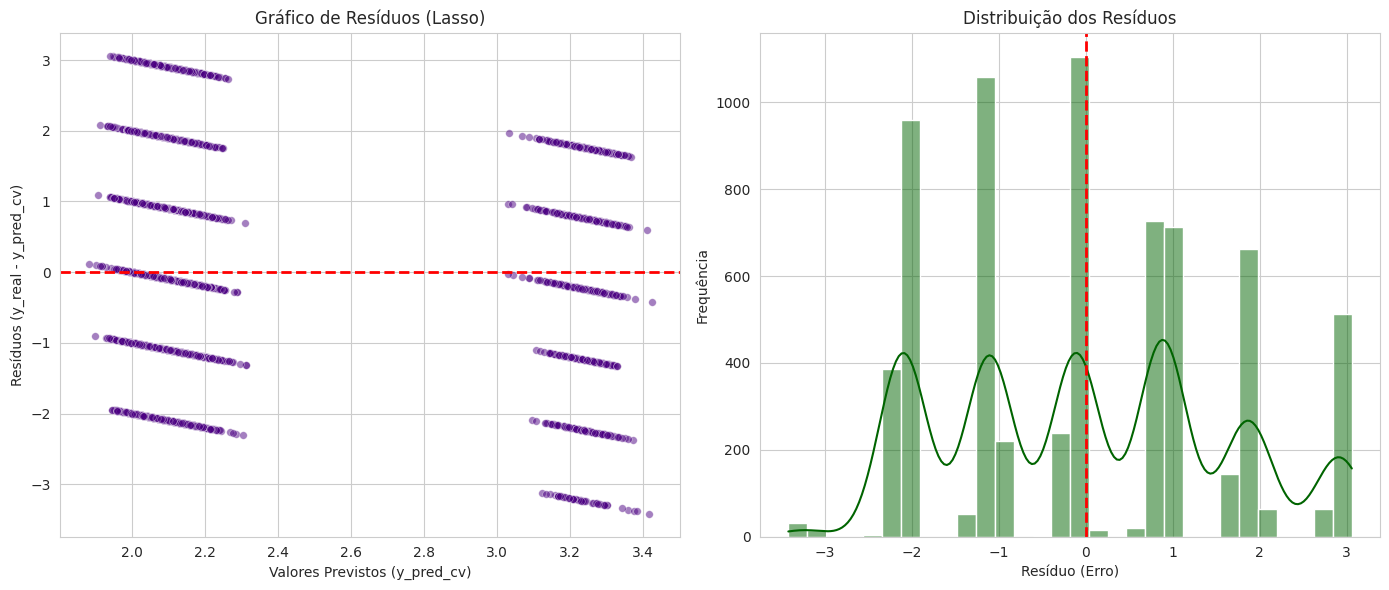


Plotando Gráfico 3: Q-Q Plot dos Resíduos...


<Figure size 600x600 with 0 Axes>

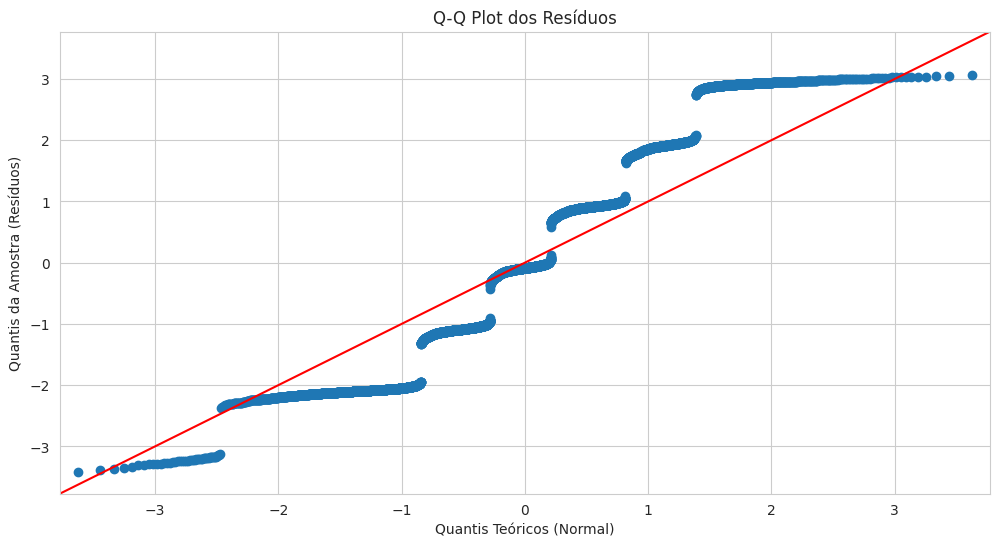


Interpretação da Análise de Resíduos:
  1. Gráfico Resíduos vs. Previstos:
     - IDEAL: Uma nuvem de pontos aleatória, sem forma, centrada na linha vermelha (y=0).
     - PROBLEMAS: Se você vir um padrão (ex: forma de 'funil' ou 'U'), isso indica que o modelo erra sistematicamente.

  2. Histograma dos Resíduos:
     - IDEAL: Uma curva de sino (distribuição normal) centrada em 0.
     - PROBLEMAS: Se a distribuição for muito assimétrica (enviesada para um lado).

  3. Q-Q Plot:
     - IDEAL: Os pontos azuis devem seguir de perto a linha diagonal vermelha.
     - PROBLEMAS: Se os pontos (especialmente nas pontas) se desviam muito da linha.


In [62]:
# =============================================================================
# CÉLULA 10: CÓDIGO - ANÁLISE DE RESÍDUOS
# =============================================================================
print("\n--- 10. Análise de Resíduos do Melhor Modelo ---")

# Importar ferramentas necessárias
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm

# --- 1. Selecionar o "Melhor Modelo" para Diagnóstico ---
# Compara os resultados da Reg. Linear (C7), Lasso (C9), Ridge (C9) e RF (C11)
try:
    model_performance = {
        'Regressão Linear (Base)': (pipeline_lr_scaled, cv_r2_scores_base.mean()), # Pipeline da Célula 8
        'Lasso': (grid_lasso.best_estimator_, best_r2_lasso),
        'Ridge': (grid_ridge.best_estimator_, best_r2_ridge),
        'Random Forest': (rf_random_search.best_estimator_, best_r2_rf)
    }

    # Encontrar o nome do modelo com o maior R²
    best_model_name = max(model_performance, key=lambda k: model_performance[k][1])
    best_model_pipeline = model_performance[best_model_name][0]

    print(f"Analisando resíduos do melhor modelo: {best_model_name} (R²: {model_performance[best_model_name][1]:.4f})")

except NameError as e:
    print(f"ERRO: Resultados dos modelos não encontrados ({e}). Execute as células 7, 9 e 11.")
    print("Assumindo Random Forest como melhor modelo por padrão.")
    best_model_pipeline = rf_random_search.best_estimator_
    best_model_name = "Random Forest (Default)"
except Exception as e:
    print(f"Erro ao selecionar melhor modelo: {e}. Assumindo Random Forest.")
    best_model_pipeline = rf_random_search.best_estimator_
    best_model_name = "Random Forest (Default)"


# --- 2. Obter Previsões (Fora da Amostra) ---
print("Gerando previsões com 'cross_val_predict'...")
try:
    # Usamos o kfold rápido (5 splits) para a predição de resíduos
    y_pred_cv = cross_val_predict(best_model_pipeline, X, y, cv=kfold_rapido, n_jobs=-1)
except Exception as e:
    print(f"Erro ao executar cross_val_predict: {e}")
    raise SystemExit()

# --- 3. Calcular Resíduos ---
residuals = y - y_pred_cv
print("Resíduos calculados (Valor Real - Valor Previsto).")

# --- 4. Plotar Diagnósticos ---

# Gráfico 1: Resíduos vs. Valores Previstos (Verifica Aleatoriedade)
print("\nPlotando Gráfico 1: Resíduos vs. Valores Previstos...")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_cv, y=residuals, alpha=0.5, s=30, color='indigo')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2) # Linha horizontal no erro zero
plt.title(f'Gráfico de Resíduos ({best_model_name})')
plt.xlabel('Valores Previstos (y_pred_cv)')
plt.ylabel('Resíduos (y_real - y_pred_cv)')
plt.grid(True)

# Gráfico 2: Histograma dos Resíduos (Verifica Normalidade)
print("Plotando Gráfico 2: Histograma dos Resíduos...")
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=30, color='darkgreen')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2) # Linha vertical no erro zero
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo (Erro)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# Gráfico 3: Q-Q Plot (Verifica Normalidade de forma mais rigorosa)
print("\nPlotando Gráfico 3: Q-Q Plot dos Resíduos...")
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45') # '45' desenha a linha de 45 graus
plt.title('Q-Q Plot dos Resíduos')
plt.xlabel('Quantis Teóricos (Normal)')
plt.ylabel('Quantis da Amostra (Resíduos)')
plt.grid(True)
plt.show()

# --- 5. Interpretação dos Gráficos ---
print("\nInterpretação da Análise de Resíduos:")
print("  1. Gráfico Resíduos vs. Previstos:")
print("     - IDEAL: Uma nuvem de pontos aleatória, sem forma, centrada na linha vermelha (y=0).")
print("     - PROBLEMAS: Se você vir um padrão (ex: forma de 'funil' ou 'U'), isso indica que o modelo erra sistematicamente.")
print("\n  2. Histograma dos Resíduos:")
print("     - IDEAL: Uma curva de sino (distribuição normal) centrada em 0.")
print("     - PROBLEMAS: Se a distribuição for muito assimétrica (enviesada para um lado).")
print("\n  3. Q-Q Plot:")
print("     - IDEAL: Os pontos azuis devem seguir de perto a linha diagonal vermelha.")
print("     - PROBLEMAS: Se os pontos (especialmente nas pontas) se desviam muito da linha.")
